<div style="background-image:url(images/meschede-seismic-waves.png); padding: 10px 30px 20px 30px; background-size:cover; background-opacity:50%; border-radius:5px; background-position: 0px -200px">
<p style="float:right; margin-top:20px; padding: 20px 60px 0px 10px; background:rgba(255,255,255,0.75); border-radius:10px;">
<img width="400px" src=images/obspy_logo_full_524x179px.png?raw=true>
</p>

<h1 style="color:#BBB; padding-bottom: 80px">MESS 2016 - Practicals</h1>

<h2 style="color:#FFF; padding-bottom: 30px">Event Detection<br/>Triggering / Coincidence Sums / Matched Filter</h2>

</div>

### Please execute first cell to have plots show up inline (and scrollable/zoomable)
### If you are unclear about how to use some ObsPy function: use search box at http://docs.obspy.org

In [1]:
import matplotlib.pyplot as plt
plt.switch_backend("nbagg")
import warnings
warnings.filterwarnings("ignore", message='The resource identifier.*')

 * read waveform data from file `events_UH1_EHZ.mseed` (contains several events)
 * print trace information
 * do the preview plot of the stream
 * zoom to one of the big events interactively (the default for the preview plot is a memory/CPU-friendly min/max plot, which gets messy when zooming in), take a note of the time of the event

<IPython.core.display.Javascript object>


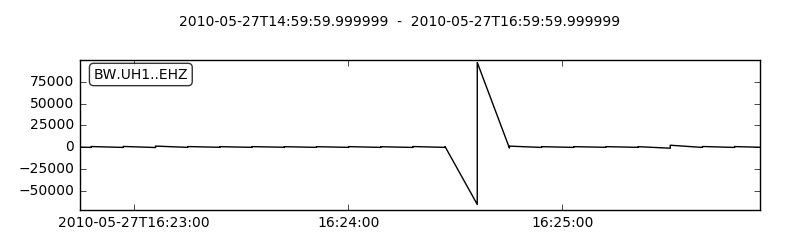

In [2]:
from obspy import read
st = read("data/events_UH1_EHZ.mseed")
st.plot()

 * use stream's `slice()` method to get a new stream with a small portion of the original stream, closely around event time (roughly 10-20 seconds)
 * plot the new short stream with the event
 * plot the spectrogram of event
 * take note of length of P wave onset and it's frequency content

<IPython.core.display.Javascript object>


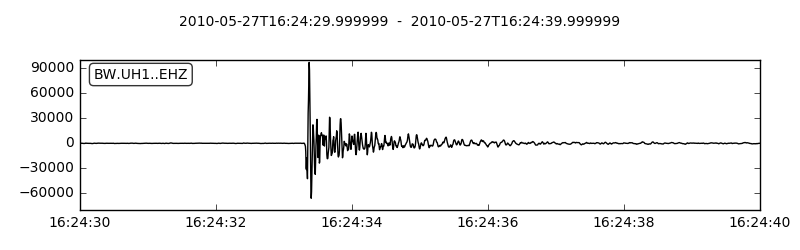

<IPython.core.display.Javascript object>


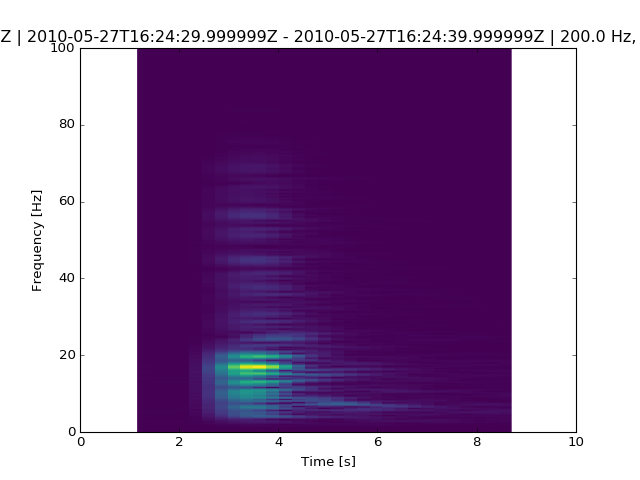

[None]

In [3]:
from obspy import UTCDateTime

t = UTCDateTime("2010-05-27T16:24:30")
st_short = st.slice(t, t+10)
st_short.plot()
st_short.spectrogram()

 * make a copy of the waveform data stream for the triggering (the triggering changes the stream's data in place)
 * run trigger routine on it, see [`Trace.trigger(...)`](http://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.trigger.html)
 
   * adjust `sta` and `lta` options to fit well with the length of the P wave onset (see above)
   * you can try a trigger method of choice (classic STA/LTA, recursive STA/LTA, ...)

* visualize trigger on/off settings (use [`plot_trigger() function`](http://docs.obspy.org/packages/autogen/obspy.signal.trigger.plot_trigger.html) from `obspy.signal.trigger` providing both original waveform and characteristic function of trigger routine)

   * try different on/off thresholds to try and detect at least the big events but not get too many false positives..

<IPython.core.display.Javascript object>


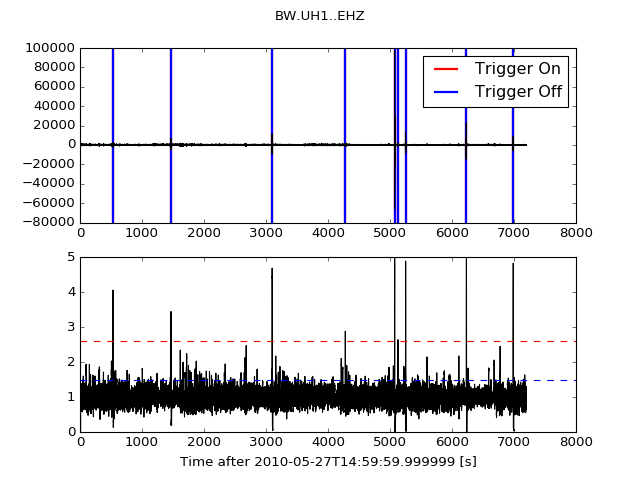

In [4]:
from obspy.signal.trigger import plot_trigger
st_trig = st.copy()
st_trig.trigger("classicstalta", sta=2, lta=10)
plot_trigger(st[0], st_trig[0].data, 2.6, 1.5)

 * here we provide two helper functions to summarize detection statistics (i.e. print count of detected events/missed events/false-positives)
 * execute the cell to be able use them below

In [5]:
from obspy import read_events
from obspy.signal.trigger import trigger_onset, plot_trigger

catalog_true_events = read_events("data/events.quakeml")

def print_trigger_statistics(trace, trigger_on, trigger_off, plot=True, **trigger_kwargs):
    """
    Provide trace, trigger settings, on and off threshold.
    Prints statistics of detected/missed events and false positives.
    
    Example:
    
        >>> print_trigger_statistics(st[0], 4, 2.5, type="classicstalta", sta=2, lta=10)
    """
    # evaluate the characteristic function
    char_func = trace.copy().trigger(**trigger_kwargs).data
    # get on/off times for given threshold values
    on_times = trigger_onset(char_func, trigger_on, trigger_off,
                             max_len=trace.stats.sampling_rate)[:, 0]
    on_times = on_times / trace.stats.sampling_rate
    event_times = []
    # for each event remember the time of the earliest pick/origin as reference
    for event in catalog_true_events:
        # we just simply use the first time stamp we encounter, either the origin or some pick
        for item in event.origins + event.picks:
            if item.time:
                event_times.append(item.time - trace.stats.starttime)
                break
    # get counts of detections and false positives
    detected = 0
    false_positives = 0
    for t_trig in on_times:
        for t_event in event_times:
            # if trigger is within 5 seconds of an event we count it as a true detection
            if abs(t_trig - t_event) < 5:
                detected += 1
                break
        else:
            false_positives += 1
    print("Detected: {}/{}\nMissed: {}\nFalse Positives: {}".format(
        detected, len(event_times), len(event_times) - detected, false_positives))
    if plot:
        plot_trigger(trace, char_func, trigger_on, trigger_off)

def print_coincidence_trigger_statistics(triggers):
    """
    Provide output of coincidence_trigger routine.
    Prints statistics of detected/missed events and false positives.
    """
    event_times = []
    # for each event remember the time of the earliest pick/origin as reference
    for event in catalog_true_events:
        # we just simply use the first time stamp we encounter, either the origin or some pick
        for item in event.origins + event.picks:
            if item.time:
                event_times.append(item.time)
                break
    # get counts of detections and false positives
    detected = 0
    false_positives = 0
    for trigger in triggers:
        t_trig = trigger["time"]
        for t_event in event_times:
            # if trigger is within 5 seconds of an event we count it as a true detection
            if abs(t_trig - t_event) < 5:
                detected += 1
                break
        else:
            false_positives += 1
    print("Detected: {}/{}\nMissed: {}\nFalse Positives: {}".format(
        detected, len(event_times), len(event_times) - detected, false_positives))

 * use the `print_trigger_statistics()` function defined above with the trigger settings you came up with above to check counts of detected events/missed events/false-positives

Detected: 7/14
Missed: 7
False Positives: 2


<IPython.core.display.Javascript object>


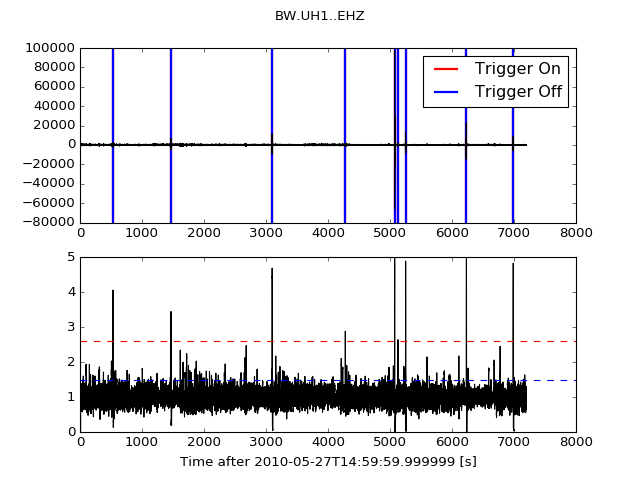

In [6]:
print_trigger_statistics(st[0], 2.6, 1.5, type="classicstalta", sta=2, lta=10)

 * try to tweak trigger settings to improve the detections and suppress false positives
 
   * filter the data to frequency band of P wave onset (see above) before triggering
   * adjust sta/lta settings

 * (Gold card member exercise: do some automatic looping over various filter settings and sta/lta settings, plot the results and use the so optimized settings)
 * print optimized detection statistics again

Detected: 8/14
Missed: 6
False Positives: 2


<IPython.core.display.Javascript object>


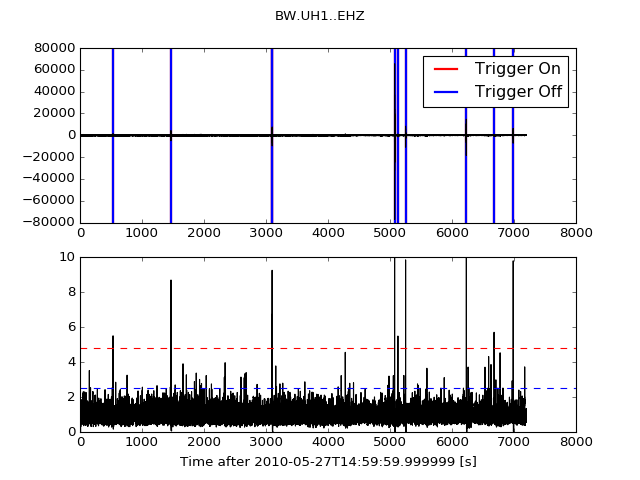

In [7]:
st2 = st.copy()
st2.filter("bandpass", freqmin=5, freqmax=20)
print_trigger_statistics(st2[0], 4.8, 2.5, type="classicstalta", sta=1, lta=10)

 * read data for "EHZ" channel from all "UH" stations into one stream (use wildcards in filename, files `events_UH*_EHZ.mseed`)
 * pre-filter data to frequency bands used above 
 * run network [`coincidence_trigger()`](http://docs.obspy.org/packages/autogen/obspy.signal.trigger.coincidence_trigger.html) (see also [trigger tutorial](https://docs.obspy.org/tutorial/code_snippets/trigger_tutorial.html#network-coincidence-trigger-example)) routine from `obspy.signal.trigger` using these four stations' vertical component

In [8]:
from obspy import read
from obspy.signal.trigger import coincidence_trigger

st = read("data/events_UH*_EHZ.mseed")
st.filter('bandpass', freqmin=5, freqmax=20)

st2 = st.copy()
triggers = coincidence_trigger("classicstalta", 2.8, 1.5, st2, thr_coincidence_sum=3,
                               trigger_off_extension=1, sta=1, lta=10)
print_coincidence_trigger_statistics(triggers)

Detected: 10/14
Missed: 4
False Positives: 1


#### Gold card members exercise:
 * here we provide a function that extracts event templates from the biggest events to use in `coincidence_trigger()` routine in option `event_templates`, execute the box to be able to use it below

In [9]:
def get_event_templates(plot=False, **filter_options):
    """
    Provide the same filter options that are used in the coincidence trigger!
    Otherwise the cross correlation is comparing apples and oranges..
    
    Example:
    
        >>> templates = get_event_templates(type="bandpass", freqmin=10, freqmax=20)
    
    plot: boolean, whether to plot first 5 templates or not
    """
    st_ = read("data/events_UH*.mseed")
    st_.filter('bandpass', freqmin=10, freqmax=20)
    cat_ = read_events("data/events.quakeml")
    event_templates = {"UH1": [], "UH2": [], "UH3": []}
    for event_ in cat_:
        if event_.magnitudes[0].mag < 1:
            continue
        for station in event_templates.keys():
            for pick in event_.picks:
                if pick.waveform_id.station_code != station:
                    continue
                if pick.phase_hint != "P":
                    continue
                st__ = st_.select(station=station).slice(pick.time, pick.time + 2.5)
                event_templates[station].append(st__)
                break
    i = 0
    if plot:
        for sta, st_list in event_templates.items():
            if i > 5:
                break
            for st_ in st_list:
                if i > 5:
                    break
                st_.plot()
                i += 1
        import matplotlib.pyplot as plt
        plt.show()
    return event_templates

#### Gold card members exercise:
 * execute the function providing the same filter settings you use for the pre-filtering in the triggering (see example in function definition above)
 * run network coincidence trigger with standard STA/LTA with coincidence sum plus additional three-component template matching (see https://docs.obspy.org/tutorial/code_snippets/trigger_tutorial.html#advanced-network-coincidence-trigger-example-with-similarity-detection)

In [10]:
event_templates = get_event_templates(plot=False, type='bandpass', freqmin=5, freqmax=20)

st = read("data/events_UH*_EH*.mseed")
st.filter(type='bandpass', freqmin=5, freqmax=20)
similarity_thresholds = 0.5
trace_ids = {"BW.UH1..EHZ": 1, "BW.UH2..EHZ": 1, "BW.UH3..EHZ": 1, "BW.UH4..EHZ": 1}

triggers = coincidence_trigger(
    "classicstalta", 2.0, 1.5, st, thr_coincidence_sum=4, sta=1, lta=10, trace_ids=trace_ids,
    trigger_off_extension=1, event_templates=event_templates, similarity_threshold=similarity_thresholds)
print_coincidence_trigger_statistics(triggers)

/home/megies/git/obspy/obspy/signal/trigger.py:669: UserWarning: At least one trace's ID was not found in the trace ID list and was disregarded (BW.UH1..EHE)
  warnings.warn(msg, UserWarning)
/home/megies/git/obspy/obspy/signal/trigger.py:669: UserWarning: At least one trace's ID was not found in the trace ID list and was disregarded (BW.UH1..EHN)
  warnings.warn(msg, UserWarning)
/home/megies/git/obspy/obspy/signal/trigger.py:669: UserWarning: At least one trace's ID was not found in the trace ID list and was disregarded (BW.UH2..EHE)
  warnings.warn(msg, UserWarning)
/home/megies/git/obspy/obspy/signal/trigger.py:669: UserWarning: At least one trace's ID was not found in the trace ID list and was disregarded (BW.UH2..EHN)
  warnings.warn(msg, UserWarning)
/home/megies/git/obspy/obspy/signal/trigger.py:669: UserWarning: At least one trace's ID was not found in the trace ID list and was disregarded (BW.UH3..EHE)
  warnings.warn(msg, UserWarning)


Detected: 13/14
Missed: 1
False Positives: 3


/home/megies/git/obspy/obspy/signal/trigger.py:669: UserWarning: At least one trace's ID was not found in the trace ID list and was disregarded (BW.UH3..EHN)
  warnings.warn(msg, UserWarning)
/home/megies/git/obspy/obspy/signal/trigger.py:669: UserWarning: At least one trace's ID was not found in the trace ID list and was disregarded (BW.UH4..EHE)
  warnings.warn(msg, UserWarning)
/home/megies/git/obspy/obspy/signal/trigger.py:669: UserWarning: At least one trace's ID was not found in the trace ID list and was disregarded (BW.UH4..EHN)
  warnings.warn(msg, UserWarning)
